# OPTIMIZING MACHINE LEARNING MODELS FOR PREDICTING GBPUSD FOREX TIME SERIES 
## A dissertation submitted in partial fulfilment of the requirements of Sheffield Hallam University for the degree of Master of Science in Big Data Analytics 
## ADAMU MORIAMO INUMIDUN
## C2066972
## 25th August, 2024 


# README 
This code is divided into the following sections: 
1. Installation and importation of needed libraries 
2. Uploading, validation, cleaning and visualization of data 
3. Data Propcessing - features engineering, differencing, normalization 
4. Splitting the data into training and test set 
5. Training the individual models - MLP, RF and GBR 
6. Testing, Performance Evaluation/Visualization and features importance of individual models 
7. Hybrid model development (MLP + RF and MLP + GBR) 
8. Training, testing and performance evaluation of hybrid models 
9. Back testing the hybrid model 
10. Optimization of individual and hybrid models.

Install all the libraries in section 1. You may comment it out afterwards to avoid reinstallation each time.\

Once the full code is running, there is a pause at section 3.

You are required to input Y or N if you wish to train the data after differencing and normalization or NOT



### 1. Installation and importation of needed libraries
#### Uncomment (delete #) and run any library that is not install on your PC 

In [4]:
# !pip install itertools
# !pip install mplfinance 
# !pip install pandas_ta
# !pip install backtesting

In [6]:
import pandas as pd
import pandas_ta as ta
import itertools
import seaborn as sns
import mplfinance as mpf
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting import set_bokeh_output

C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### 2. Uploading, validation, cleaning and visualization of data
#### Ensure the data - GBP_USD_Data.csv is stored in the same directory as this code

In [9]:
# SUMMARIZE AND GET OVERVIEW OF DATA
csv_file_path = 'GBP_USD_Data.csv'
df = pd.read_csv(csv_file_path) # convert data from csv to dataframe

# Rename columns to commence data validation
df.columns = df.columns.str.strip()
df.rename(columns={'DATE': 'Date', 'OPEN': 'Open', 'HIGH': 'High', 'LOW': 'Low', 'CLOSE': 'Close'}, inplace=True)

print(df.head())
print(df.info())
print(df.describe())


         Date    Open   Close    High     Low
0  05/01/2010  1.6085  1.6085  1.6154  1.5966
1  06/01/2010  1.5992  1.5992  1.6064  1.5939
2  07/01/2010  1.6019  1.6019  1.6058  1.5897
3  08/01/2010  1.5933  1.5933  1.6110  1.5916
4  11/01/2010  1.6039  1.6023  1.6194  1.6038
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3759 entries, 0 to 3758
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3759 non-null   object 
 1   Open    3759 non-null   float64
 2   Close   3759 non-null   float64
 3   High    3759 non-null   float64
 4   Low     3759 non-null   float64
dtypes: float64(4), object(1)
memory usage: 147.0+ KB
None
              Open        Close         High          Low
count  3759.000000  3759.000000  3759.000000  3759.000000
mean      1.414914     1.414937     1.420561     1.408980
std       0.152324     0.152322     0.152278     0.152327
min       1.068900     1.068900     1.083800     1.035000
25%       

#### DATA CLEANING
1. check for missing data i.e. null values in the dataset. This dataset has no null values hence, no need to drop rows with null values
2. There are no duplicate rows in the dataset hence, no need to drop any rows
3. the date format on the DATE column poses an issue and has to be changed to '%d/%m/%Y' format to work with datetime
4. The data Validation confirms that the data is in the format that it is expected to be

In [12]:
# DATA CLEANING 

print(df.isnull().sum())  # Check for missing values
print(df.duplicated().sum())  # Check for duplicates

# Ensure correct data types by Conversion date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')  # 
df = df.set_index('Date')
print(df.dtypes)

Date     0
Open     0
Close    0
High     0
Low      0
dtype: int64
0
Open     float64
Close    float64
High     float64
Low      float64
dtype: object


In [14]:
# Data Validation Functions
def validate_columns(df, expected_columns):
    actual_columns = set(df.columns)
    missing_columns = expected_columns - actual_columns
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")
    print("All expected columns are present.")

def validate_dtypes(df, expected_dtypes):
    actual_dtypes = df.dtypes
    for column, expected_dtype in expected_dtypes.items():
        if actual_dtypes[column] != expected_dtype:
            raise ValueError(f"Column '{column}' has incorrect dtype: {actual_dtypes[column]} (expected {expected_dtype})")
    print("All columns have correct data types.")

def validate_date_range_and_order(df):
    if not df.index.is_monotonic_increasing:
        raise ValueError("Dates are not sorted in ascending order.")
    if df.index.duplicated().any():
        raise ValueError("Duplicate dates found.")
    print("Date range and order are valid.")

def validate_numeric_values(df, numeric_columns):
    for column in numeric_columns:
        if (df[column] <= 0).any():
            raise ValueError(f"Column '{column}' contains non-positive values.")
        if df[column].isnull().any():
            raise ValueError(f"Column '{column}' contains missing values.")
    print("Numeric values are valid.")

def validate_missing_values(df, critical_columns):
    missing_values = df[critical_columns].isnull().sum()
    if missing_values.any():
        raise ValueError(f"Missing values found in critical columns: {missing_values[missing_values > 0]}")
    print("No missing values in critical columns.")

# Expected Columns and Data Types
expected_columns = {'Open', 'High', 'Low', 'Close'}
expected_dtypes = {'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64'}

# Validate Data
validate_columns(df, expected_columns)
validate_dtypes(df, expected_dtypes)
validate_date_range_and_order(df)
validate_numeric_values(df, ['Open', 'High', 'Low', 'Close'])
validate_missing_values(df, ['Open', 'High', 'Low', 'Close'])

print("Data validation completed successfully.")

All expected columns are present.
All columns have correct data types.
Date range and order are valid.
Numeric values are valid.
No missing values in critical columns.
Data validation completed successfully.


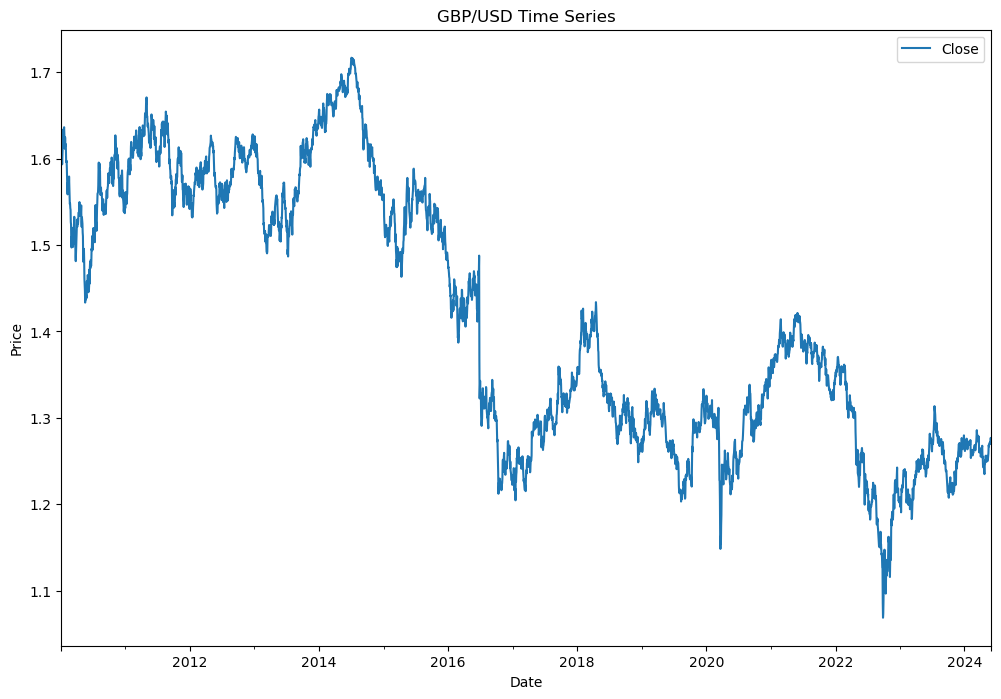

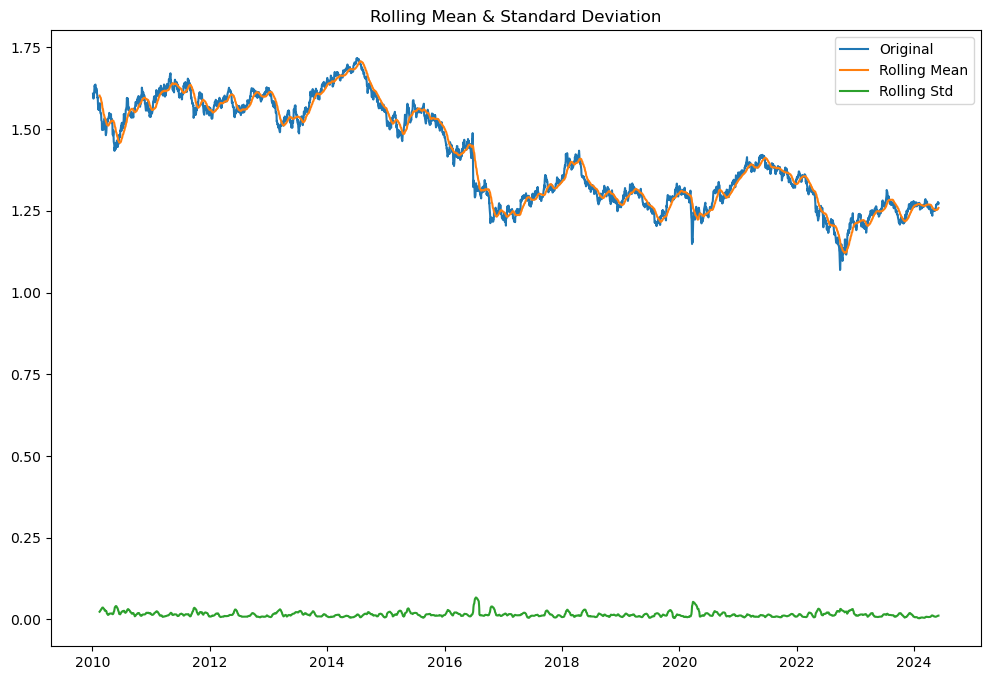

In [16]:
# DATA VISUALIZATION

# Plot the time series data
# df[['OPEN', 'CLOSE', 'HIGH', 'LOW']].plot(figsize=(12, 8))
df[['Close']].plot(figsize=(12, 8))
plt.title('GBP/USD Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate and plot rolling mean and standard deviation
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(12, 8))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

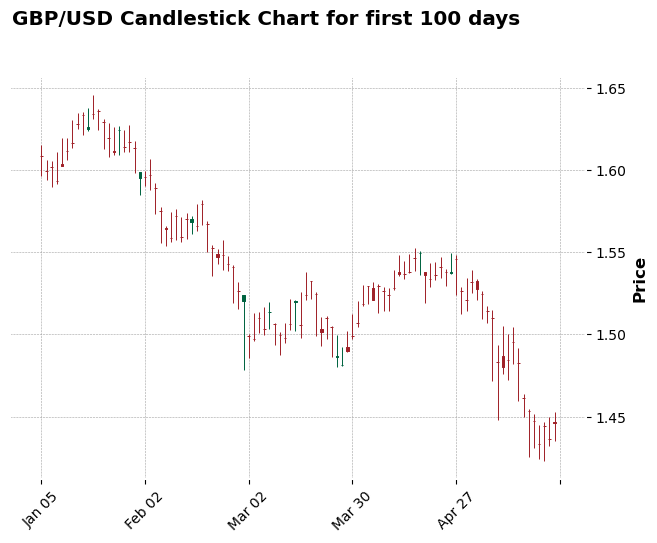

In [18]:
# Visualization of the first 100 days of data in candle stick format
df_ohlc = df.iloc[:100][['Open', 'High', 'Low', 'Close']] # limit visualization to first 100

mpf.plot(df_ohlc, type='candle', style='charles', title='GBP/USD Candlestick Chart for first 100 days', ylabel='Price', volume=False)

### 3. Data Propcessing - features engineering, features importance, differencing, normalization
N.B: Please Skip the DIFFERENCING AND NORMALIZATION SECTIONS in order to test without both operations


In [23]:
train_mode = input("Train using differencing and normalization? (Y)es or (N)o: ")

Train using differencing and normalization? (Y)es or (N)o:  N


In [25]:
# DIFFERENCING !!!

# Perform ADF test to check to stationarity(p-value should be > 0.05)
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Check if data is stationary
if result[1] > 0.05:
    print("Series is non-stationary, applying differencing.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("Series is stationary, no differencing needed.")
    df['Close_diff'] = df['Close']
    
df.dropna(inplace=True)
print('Result for ADF test after differencing')   
result = adfuller(df['Close_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if train_mode == 'Y':
    df['Close'] = df['Close_diff']
else:
    df['Close'] = df['Close']

ADF Statistic: -1.684570956101777
p-value: 0.4390790028640666
Series is non-stationary, applying differencing.
Result for ADF test after differencing
ADF Statistic: -60.59422838369744
p-value: 0.0


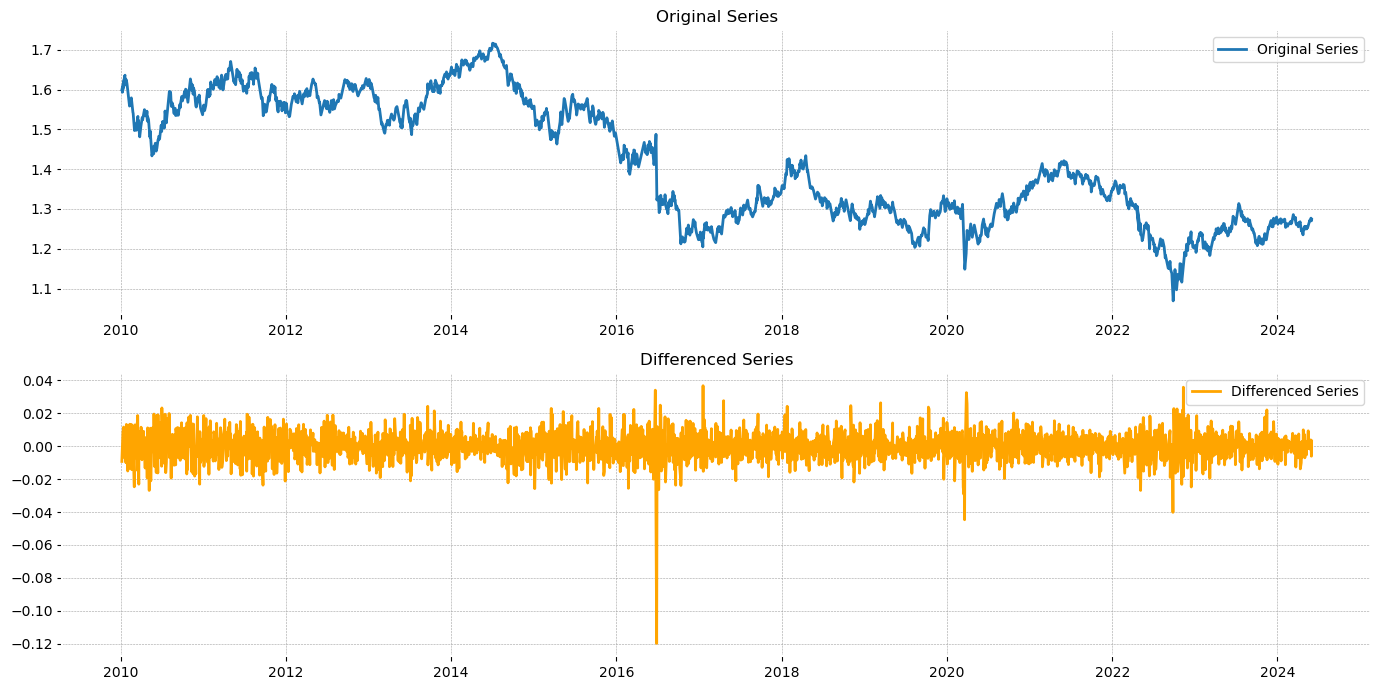

In [27]:
# Plot original series
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Original Series')
plt.title('Original Series')
plt.legend()

# Plot differenced series
plt.subplot(2, 1, 2)
plt.plot(df['Close_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Series')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# FEATURE ENGINEERING - ADDITION OF TECHNICAL INDICATORS 

# percentage change in the close price
df['pct_change'] = df['Close'].pct_change(periods=1)
if np.isinf(df).values.sum() > 0:
    df = df.drop('pct_change', axis=1)

# Add technical indicators
df['MA'] = ta.sma(df['Close'], length=20)
bband_df = ta.bbands(df['Close'], length=20)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = [bband_df['BBL_20_2.0'], bband_df['BBM_20_2.0'], bband_df['BBU_20_2.0']]
macd_df = ta.macd(df['Close'])
df['MACD'], df['MACD_signal'], df['MACD_hist'] = [macd_df['MACD_12_26_9'], macd_df['MACDh_12_26_9'], macd_df['MACDs_12_26_9']]
df['RSI'] = ta.rsi(df['Close'], length=14)

# Drop rows with NaN values created by the technical indicators
df.dropna(inplace=True)

df.tail()

,Open,Close,High,Low,Close_diff,pct_change,MA,BB_upper,BB_middle,BB_lower,MACD,MACD_signal,MACD_hist,RSI
Date,,,,,,,,,,,,,,
2024-05-27,1.2732,1.2737,1.2778,1.2729,0.0038,0.002992,1.26028,1.243172,1.26028,1.277388,0.004888,0.001897,0.002991,66.585584
2024-05-28,1.2769,1.2769,1.2801,1.2754,0.0032,0.002512,1.26131,1.242857,1.26131,1.279763,0.005374,0.001906,0.003467,69.206491
2024-05-29,1.2761,1.2762,1.2772,1.2699,-0.0007,-0.000548,1.26266,1.243999,1.26266,1.281321,0.005637,0.001736,0.003901,67.950907
2024-05-30,1.2701,1.2701,1.2747,1.2681,-0.0061,-0.004780,1.26353,1.245187,1.26353,1.281873,0.005293,0.001113,0.004180,58.064742
2024-05-31,1.2732,1.2732,1.2736,1.2700,0.0031,0.002441,1.26452,1.246335,1.26452,1.282705,0.005210,0.000824,0.004386,61.157569


In [31]:
df.describe()

,Open,Close,High,Low,Close_diff,pct_change,MA,BB_upper,BB_middle,BB_lower,MACD,MACD_signal,MACD_hist,RSI
count,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000,3725.000000
mean,1.413242,1.413265,1.418877,1.407336,-0.000075,-0.000038,1.414039,1.389709,1.414039,1.438369,-0.000644,0.000024,-0.000668,49.509286
std,0.151987,0.151984,0.151923,0.152020,0.007762,0.005611,0.151392,0.152221,0.151392,0.151716,0.008076,0.002577,0.007565,11.648849
min,1.068900,1.068900,1.083800,1.035000,-0.119800,-0.080527,1.112915,1.068740,1.112915,1.151874,-0.039415,-0.014570,-0.033169,12.887321
25%,1.279200,1.279300,1.284200,1.273100,-0.004300,-0.003098,1.281460,1.258923,1.281460,1.304779,-0.005540,-0.001533,-0.005457,41.820868
50%,1.377100,1.377000,1.381500,1.373300,0.000000,0.000000,1.380055,1.362431,1.380055,1.398503,0.000099,0.000035,0.000119,50.183101
75%,1.560200,1.560000,1.566600,1.554100,0.004400,0.003104,1.559500,1.534635,1.559500,1.585902,0.005118,0.001702,0.004778,57.900969
max,1.716600,1.716600,1.719200,1.714100,0.036700,0.031520,1.711010,1.702528,1.711010,1.723602,0.023277,0.008029,0.020701,84.128611


In [33]:
# NORMALIZATION !!!
if train_mode == 'Y':
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    data = pd.DataFrame(scaled_data)
else:
    data = df

In [35]:
# Feature Engineering
lag = 60
# lag = 30
X, y = [], []
for i in range(lag, len(data)):
    X.append(data[i-lag:i])
    y.append(data.iloc[i, 1])  # the close column is the target
    # y.append(data.iloc[i, 4])  # the percentage change column is the target
X, y = np.array(X), np.array(y)

X_reshaped = X.reshape(X.shape[0], -1) # Reshape data for MLP input


### 4. Splitting the data into training and test set /
Data is split into 80% training and 20% test sets. Shuffle is turned off because it is a timeseries

In [38]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, shuffle=False, random_state=42) # 20% testset

### 5. Training the individual models - MLP, RF and GBR 

In [41]:
# Train individual models
MLP = MLPRegressor(hidden_layer_sizes=(5, 5), max_iter=1000, early_stopping=True, alpha=0.01)

RF = RandomForestRegressor()#n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
                            # RandomForestRegressor(n_estimators=100)

GBR = GradientBoostingRegressor()#n_estimators=100, learning_rate=0.01, max_depth=3, min_samples_split=2)
                            # GradientBoostingRegressor(n_estimators=100)

models = {'MLP': MLP, 'RF': RF, 'GBR': GBR,}
# models = { 'GBR': GBR,}
# Fit models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name, " DONE ", model ,"\n")
    

MLP  DONE  MLPRegressor(alpha=0.01, early_stopping=True, hidden_layer_sizes=(5, 5),
             max_iter=1000) 

RF  DONE  RandomForestRegressor() 

GBR  DONE  GradientBoostingRegressor() 



### 6. Testing, Performance Evaluation/Visualization and features importance of individual models 

In [44]:
# predict price for the test set
y_pred_dict = {name: model.predict(X_test) for name, model in models.items()}
mlp_y_pred = MLP.predict(X_test)
rf_y_pred = RF.predict(X_test)
gbr_y_pred = GBR.predict(X_test)

In [46]:
# Function Mean Dzirectional Accuracy (MDA) Calculator
def mean_directional_accuracy(actuals, preds):

    actuals = np.array(actuals)
    preds = np.array(preds)
    
    return np.mean((np.sign(actuals[1:] - actuals[:-1]) == np.sign(preds[1:] - preds[:-1])))


In [48]:
# Calculate performance metrics for each model
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    #mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mda = mean_directional_accuracy(y_true, y_pred)
    return mse, r2, mda

# metrics = pd.DataFrame()
metrics = {}
for name, y_pred in y_pred_dict.items():
    metrics[name] = calculate_metrics(y_test, y_pred)

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame(metrics, index=['MSE', 'R2', 'MDA']).T

print(metrics_df)

          MSE        R2       MDA
MLP  0.000145  0.963854  0.480874
RF   0.000331  0.917402  0.685792
GBR  0.000222  0.944487  0.642077


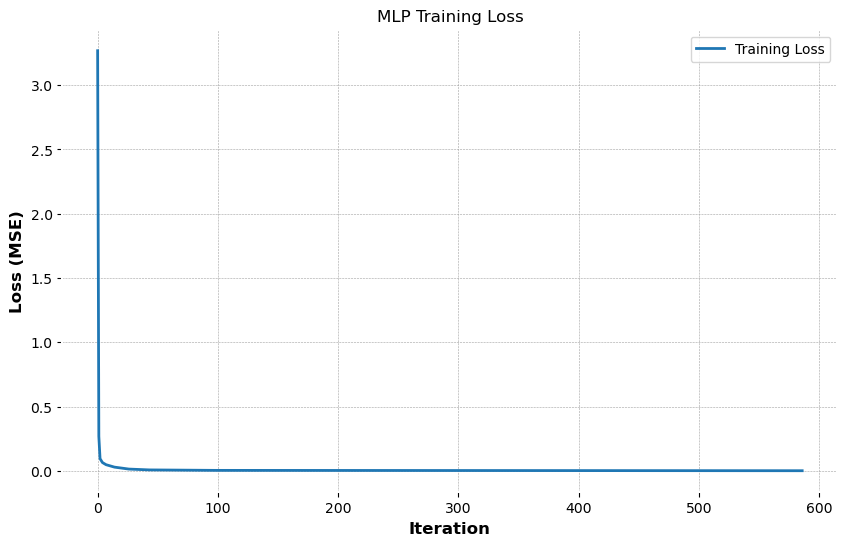

In [50]:
# MLP loss curve
# Calculate validation loss for each iteration
training_loss = MLP.loss_curve_
y_val_pred = MLP.predict(X_test)
validation_loss = mean_squared_error(y_test, y_val_pred)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
# plt.axhline(y=validation_loss, color='r', linestyle='--', label='Validation Loss')
plt.title('MLP Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

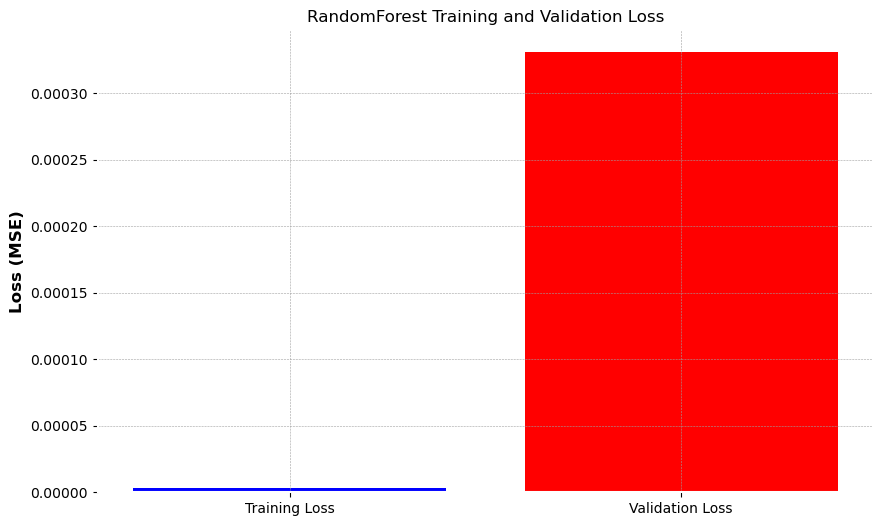

In [52]:
# RF Loss Chart
# Predict and calculate loss
train_loss_rf = mean_squared_error(y_train, RF.predict(X_train))
val_loss_rf = mean_squared_error(y_test, RF.predict(X_test))


# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.bar(['Training Loss', 'Validation Loss'], [train_loss_rf, val_loss_rf], color=['blue', 'red'])
plt.title('RandomForest Training and Validation Loss')
plt.ylabel('Loss (MSE)')
plt.show()

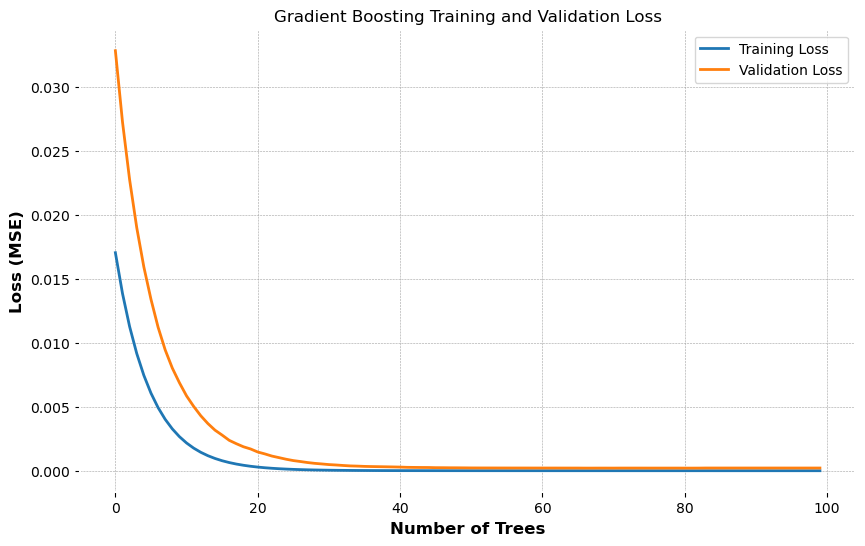

In [54]:
# GBR Loss Curve
train_loss_gbr = [mean_squared_error(y_train, y_pred) for y_pred in GBR.staged_predict(X_train)]
val_loss_gbr = [mean_squared_error(y_test, y_pred) for y_pred in GBR.staged_predict(X_test)]

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss_gbr, label='Training Loss')
plt.plot(val_loss_gbr, label='Validation Loss')
plt.title('Gradient Boosting Training and Validation Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

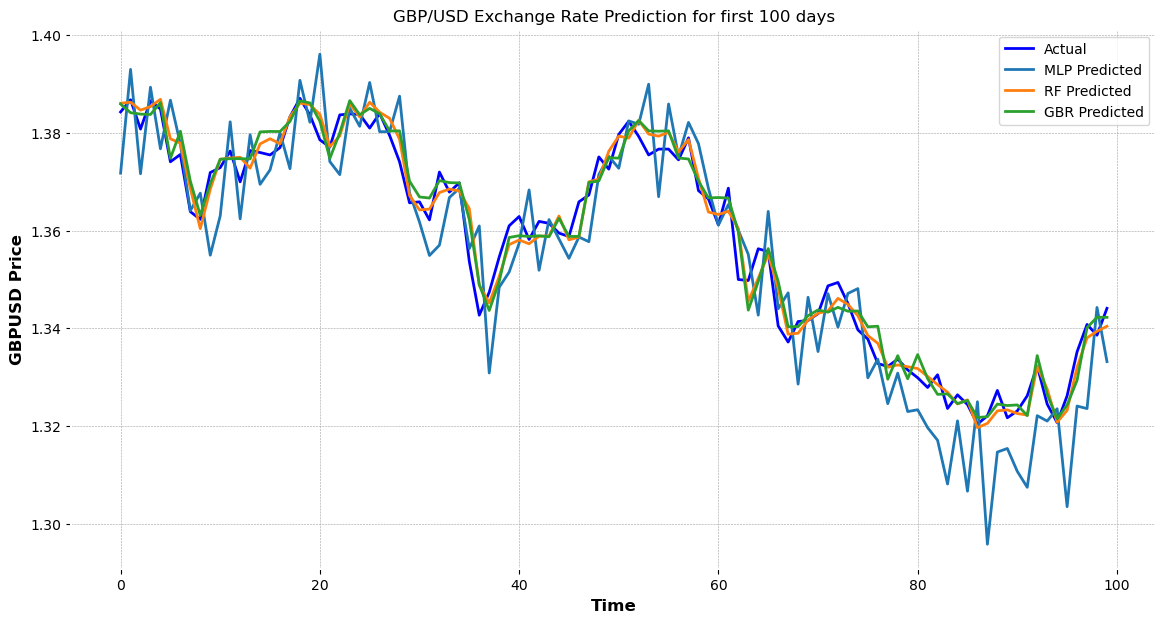

In [56]:
# Plot the results
def plot_results(y_test, y_pred_dict):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[:100], color='blue', label='Actual')
    for model_name, y_pred in y_pred_dict.items():
        plt.plot(y_pred[:100], label=f'{model_name} Predicted')
    plt.title('GBP/USD Exchange Rate Prediction for first 100 days')
    plt.xlabel('Time')
    plt.ylabel('GBPUSD Price')
    plt.legend()
    plt.show()
    
# y_pred_dict = np.array(y_pred_dict)
plot_results(y_test, y_pred_dict)

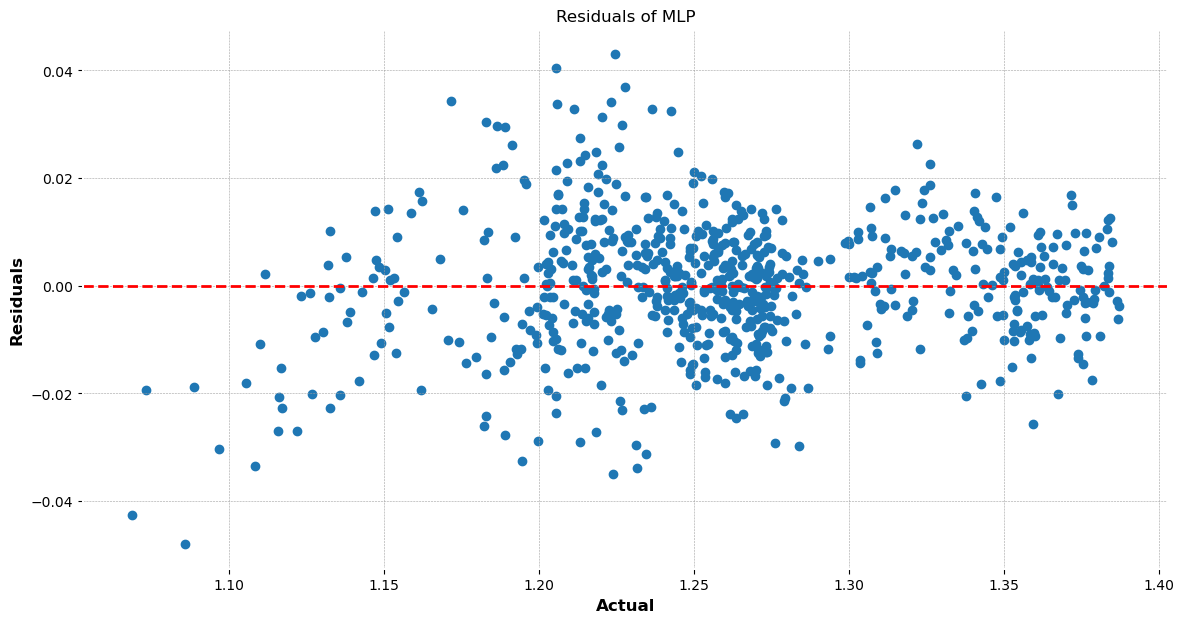

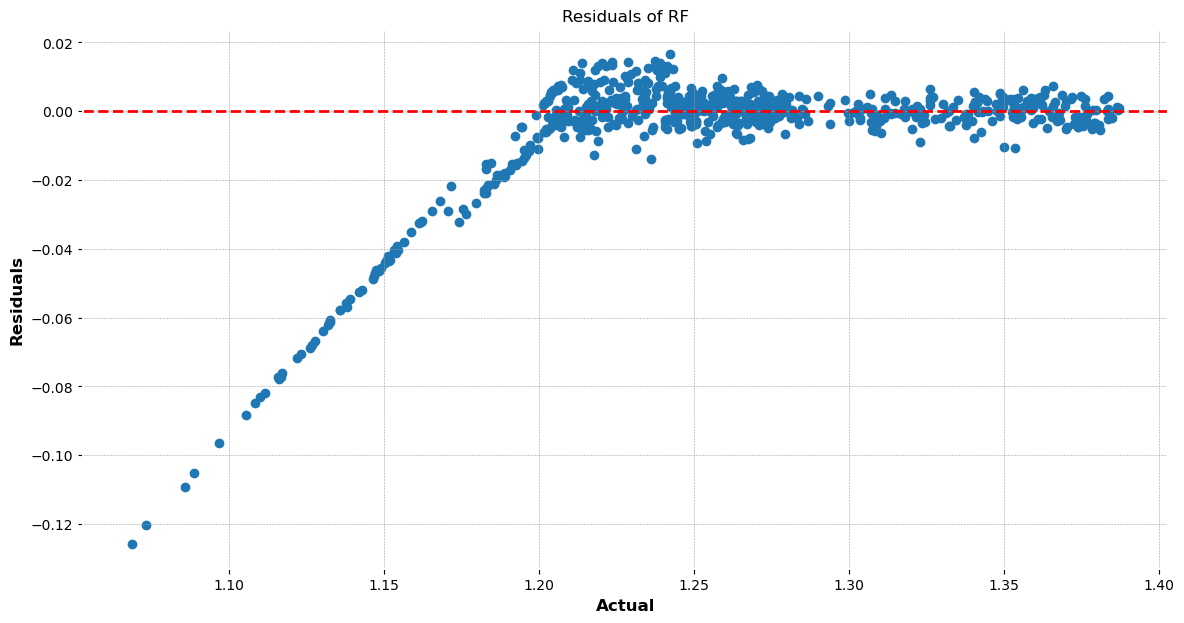

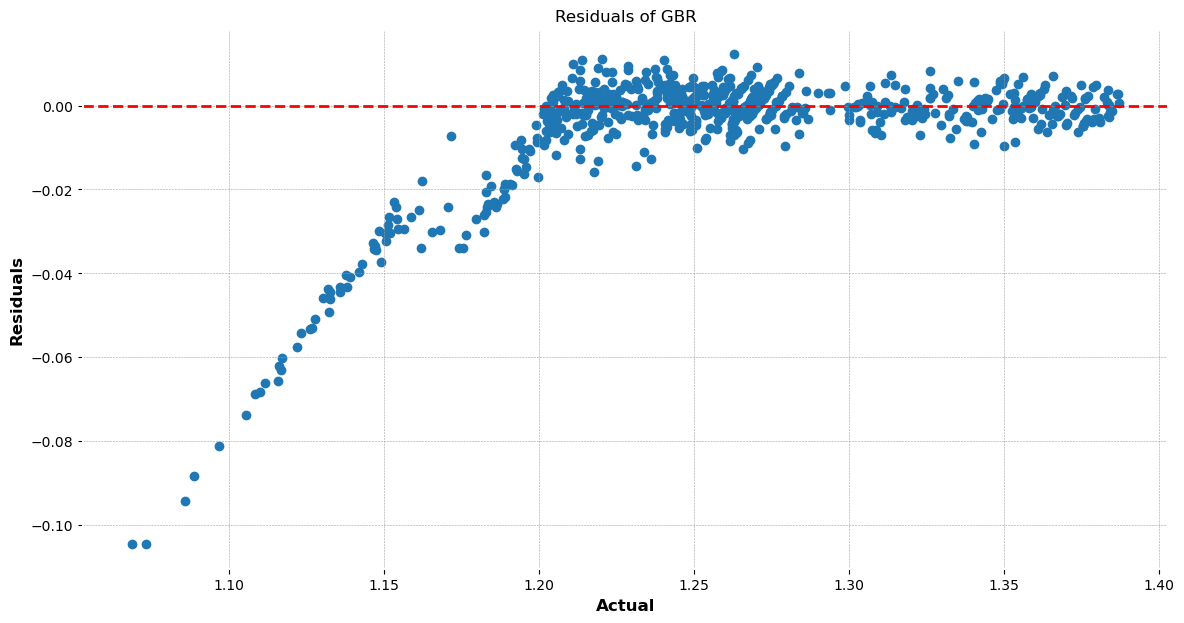

In [58]:
# Residual Analysis
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(14, 7))
    plt.scatter(y_test, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals of {model_name}')
    plt.xlabel('Actual')
    plt.ylabel('Residuals')
    plt.show()

for name, y_pred in y_pred_dict.items():
    plot_residuals(y_test, y_pred, name)

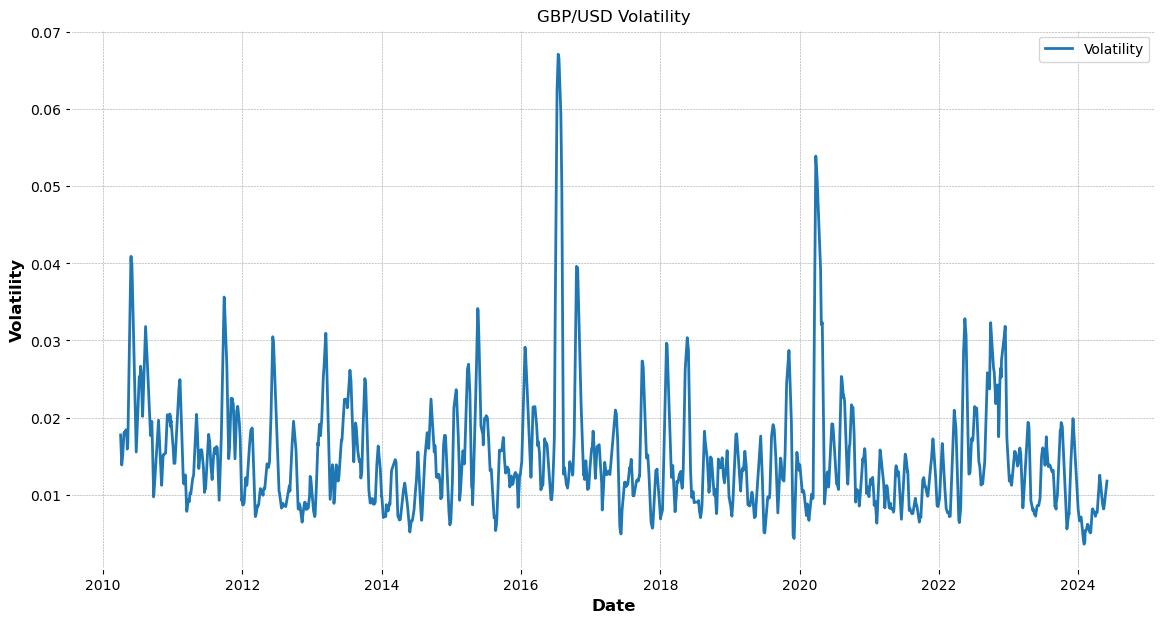

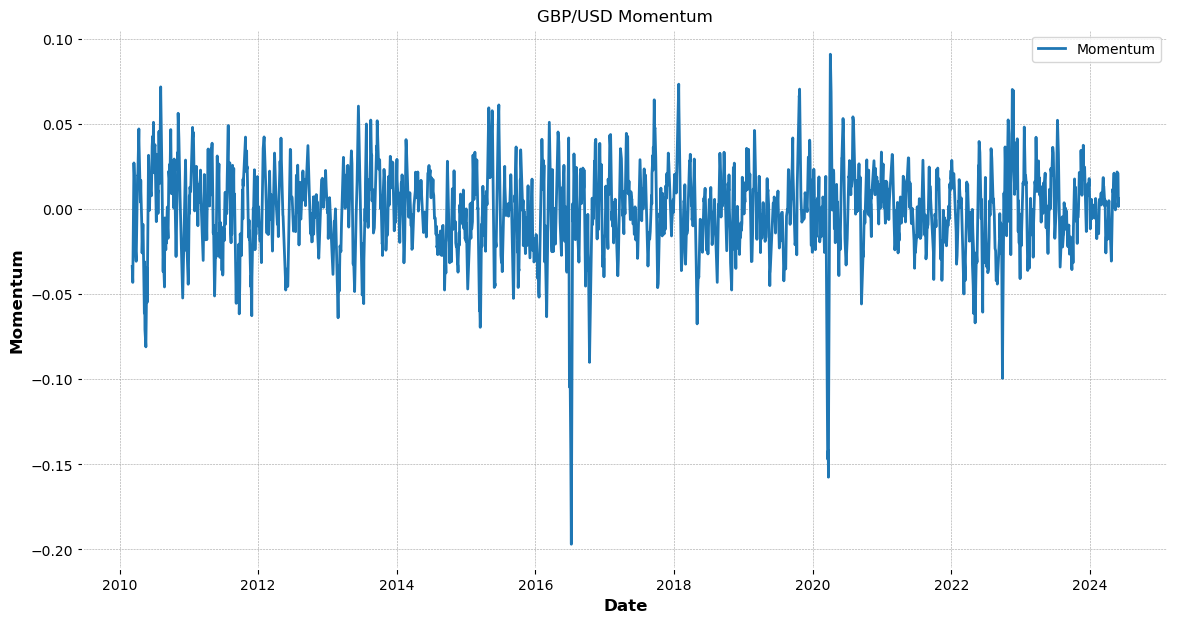

In [60]:
# Analyze price dynamics
def plot_price_dynamics(df):
    # volatility
    volatility = df['Close'].rolling(window=30).std()
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, volatility, label='Volatility')
    plt.title('GBP/USD Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

    # momentum
    momentum = df['Close'].diff(10)
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, momentum, label='Momentum')
    plt.title('GBP/USD Momentum')
    plt.xlabel('Date')
    plt.ylabel('Momentum')
    plt.legend()
    plt.show()

plot_price_dynamics(df)

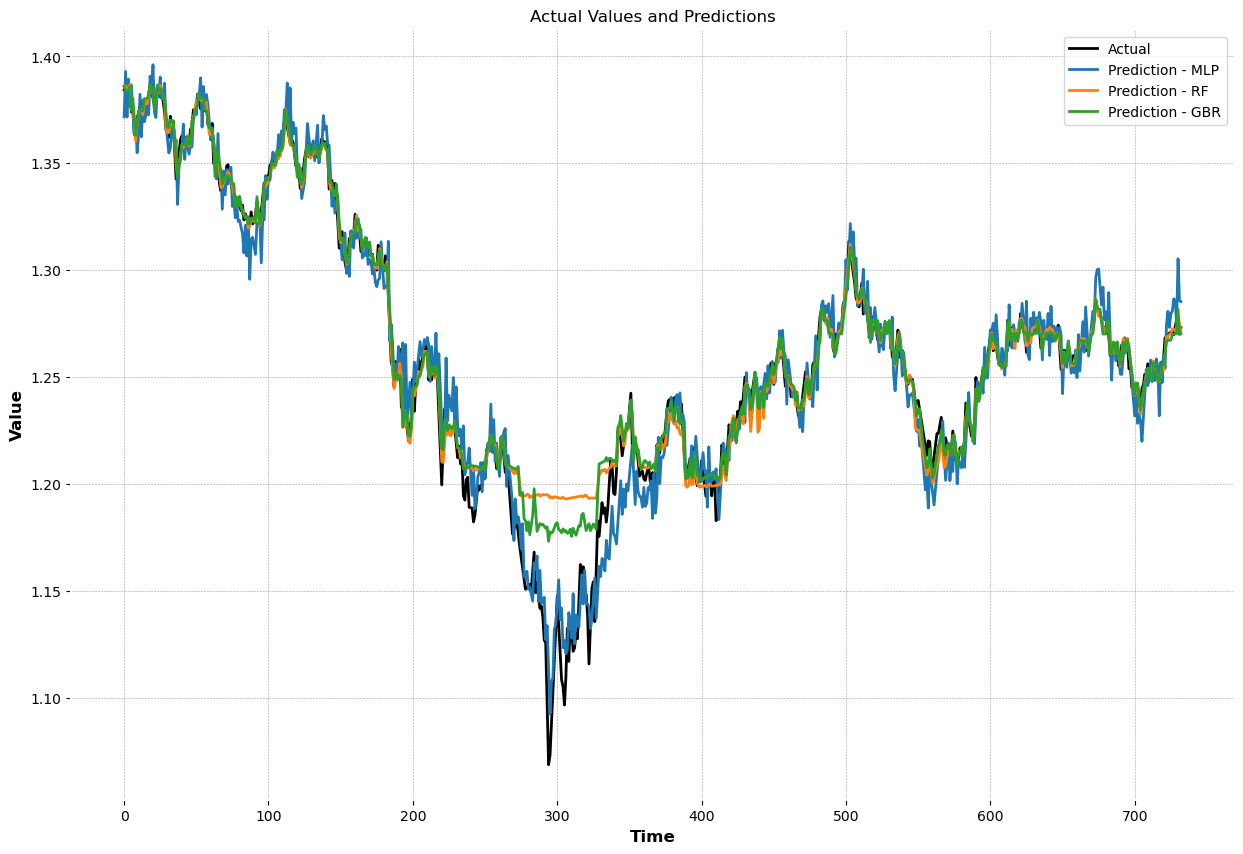

In [62]:
# Plot Actual vs Predicted GBPUSD prices
pred_vals = {}
for name, y_pred in y_pred_dict.items():
    pred_vals[name] = y_pred

# Plotting the predicted and the actual values
plt.figure(figsize=(15, 10))

# Plot the actual values
plt.plot(y_test, label='Actual', color='black')

# Plot the absolute errors for each model
for name, pred_val in pred_vals.items():
    plt.plot(pred_val, label=f'Prediction - {name}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual Values and Predictions')
plt.legend()

# Show the plot
plt.show()

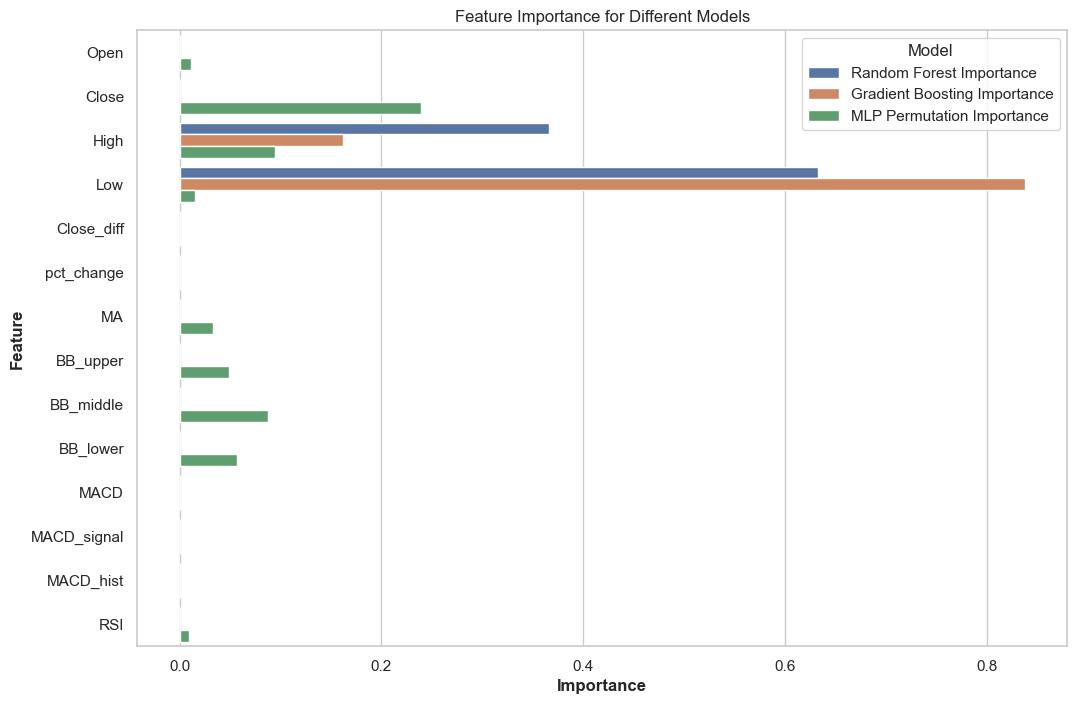

In [64]:
# FEATURE IMPORTANCE

X_tr, X_te, y_tr, y_te = train_test_split(df.iloc[:-1], df.iloc[1:, 1], test_size=0.2, shuffle=False, random_state=42) # 20% testset
MLP.fit(X_tr, y_tr) 
RF.fit(X_tr, y_tr)  
GBR.fit(X_tr, y_tr)  

# Feature importance for Random Forest and Gradient Boosting Regressor
rf_importance = RF.feature_importances_
gbr_importance = GBR.feature_importances_

# Permutation importance for MLP
perm_importance = permutation_importance(MLP, X_tr, y_tr, n_repeats=10)
feature_names = X_tr.columns.tolist()

# Create a DataFrame for feature importance
#feature_names = [f'lag_{i}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest Importance': rf_importance,
    'Gradient Boosting Importance': gbr_importance,
    'MLP Permutation Importance': perm_importance.importances_mean
})

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
importance_df = importance_df.melt(id_vars=['Feature'], var_name='Model', value_name='Importance')
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df)
plt.title('Feature Importance for Different Models')
plt.show()

# HYBRID MODEL
### 7.	Hybrid model development (MLP + RF and MLP + GBR) 

In [67]:
# Define base/estimator model
mlp = MLPRegressor(hidden_layer_sizes=(5, 5), max_iter=1000, early_stopping=True, alpha=0.01)
rf = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)



# Define the stacking ensemble model
# MLP + RF
mlp_rf_ensemble = StackingRegressor(
    #estimators=[('mlp', mlp), ('rf', rf)],
    estimators=[('mlp', mlp)],
    
    # final_estimator=meta_model
    final_estimator=rf
)

# MLP + GBR
mlp_gbr_ensemble = StackingRegressor(
    #estimators=[('mlp', mlp), ('gbr', gbr)],
    estimators=[('mlp', mlp)],
    
    # final_estimator=meta_model
    final_estimator=gbr
)



In [69]:
# data processing

# Feature Engineering
"""
lag = 60
# lag = 30
data = df # scaled_data
X, y = [], []
for i in range(lag, len(data)):
    X.append(data[i-lag:i])
    y.append(data.iloc[i, 1])  # the close column is the target
    # y.append(data.iloc[i, 4])  # the percentage change column is the target
X, y = np.array(X), np.array(y)

X_reshaped = X.reshape(X.shape[0], -1) # Reshape data for MLP input

X_reshaped= df.iloc[:-1]
y = df.iloc[1:, 1]
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, shuffle=False, random_state=42) # 20% testset
"""

# Convert data to dataframe
X_new = pd.DataFrame(df)
y_new = pd.DataFrame(df.iloc[:,1])


## 8.	Training, testing and performance evaluation of hybrid models 
### Recurrent training and prediction
Retrains the model after each day. The Batch size (n) for each training set is 50 days \
The Number of days to be tested (ii) is set to 100 days 

In [72]:
# recurrent training and prediction - retrains the model after each day
y_pred_mlp_rf = pd.DataFrame()
y_pred_mlp_gbr = pd.DataFrame()

n = 50 # batch size for the training set
iii = 100 # no of days to test

for i in range(len(X_new)-iii,len(X_new)-1):
    # Training
    mlp_rf_ensemble.fit(X_new[i-n:i], y_new[i-n+1:i+1])
    mlp_gbr_ensemble.fit(X_new[i-n:i], y_new[i-n+1:i+1])
    print((i-len(X_new)+iii+1)*100/iii,'% done ', len(X_new)-i-1, 'training and test to go . . . ')
    
    # Testing
    y_pred_mlp_rf_new = mlp_rf_ensemble.predict(X_new.iloc[[i+1]])
    y_pred_mlp_gbr_new = mlp_gbr_ensemble.predict(X_new.iloc[[i+1]])
    
    y_pred_mlp_rf = pd.concat([y_pred_mlp_rf, pd.DataFrame(y_pred_mlp_rf_new)])
    y_pred_mlp_gbr = pd.concat([y_pred_mlp_gbr, pd.DataFrame(y_pred_mlp_gbr_new)])
    
y_pred_mlp_rf.reset_index(inplace = True, drop = True)
y_pred_mlp_gbr.reset_index(inplace = True, drop = True)   
y_pred_mlp_gbr.columns = ['Close']
y_pred_mlp_rf.columns = ['Close']

C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0 % done  99 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

2.0 % done  98 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3.0 % done  97 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

4.0 % done  96 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

5.0 % done  95 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

6.0 % done  94 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


7.0 % done  93 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


8.0 % done  92 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

9.0 % done  91 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

10.0 % done  90 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

11.0 % done  89 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12.0 % done  88 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

13.0 % done  87 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

14.0 % done  86 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

15.0 % done  85 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


16.0 % done  84 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

17.0 % done  83 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

18.0 % done  82 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


19.0 % done  81 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


20.0 % done  80 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

21.0 % done  79 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maria

22.0 % done  78 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

23.0 % done  77 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

24.0 % done  76 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

25.0 % done  75 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


26.0 % done  74 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

27.0 % done  73 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

28.0 % done  72 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

29.0 % done  71 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


30.0 % done  70 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

31.0 % done  69 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\

32.0 % done  68 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33.0 % done  67 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

34.0 % done  66 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

35.0 % done  65 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


36.0 % done  64 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


37.0 % done  63 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

38.0 % done  62 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

39.0 % done  61 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

40.0 % done  60 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


41.0 % done  59 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


42.0 % done  58 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

43.0 % done  57 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


44.0 % done  56 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

45.0 % done  55 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

46.0 % done  54 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maria

47.0 % done  53 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

48.0 % done  52 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

49.0 % done  51 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


50.0 % done  50 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

51.0 % done  49 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

52.0 % done  48 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


53.0 % done  47 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

54.0 % done  46 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


55.0 % done  45 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


56.0 % done  44 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

57.0 % done  43 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

58.0 % done  42 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


59.0 % done  41 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

60.0 % done  40 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

61.0 % done  39 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


62.0 % done  38 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


63.0 % done  37 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

64.0 % done  36 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

65.0 % done  35 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

66.0 % done  34 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

67.0 % done  33 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

68.0 % done  32 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


69.0 % done  31 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

70.0 % done  30 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


71.0 % done  29 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

72.0 % done  28 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

73.0 % done  27 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

74.0 % done  26 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

75.0 % done  25 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

76.0 % done  24 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

77.0 % done  23 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.0 % done  22 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


79.0 % done  21 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

80.0 % done  20 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

81.0 % done  19 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


82.0 % done  18 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

83.0 % done  17 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

84.0 % done  16 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


85.0 % done  15 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

86.0 % done  14 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


87.0 % done  13 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\maria

88.0 % done  12 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

89.0 % done  11 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


90.0 % done  10 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

91.0 % done  9 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

92.0 % done  8 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


93.0 % done  7 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

94.0 % done  6 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

95.0 % done  5 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


96.0 % done  4 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

97.0 % done  3 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

98.0 % done  2 training and test to go . . . 


C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:967: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mariam.000\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


99.0 % done  1 training and test to go . . . 


In [74]:
# Evaluate the predictions
ii = iii-1
mse_mlp_rf = mean_squared_error(y_new[-ii:], y_pred_mlp_rf)
r2_mlp_rf = r2_score(y_new[-ii:], y_pred_mlp_rf)

mse_mlp_gbr = mean_squared_error(y_new[-ii:], y_pred_mlp_gbr)
r2_mlp_gbr = r2_score(y_new[-ii:], y_pred_mlp_gbr)

mda_mlp_rf = mean_directional_accuracy(y_new[-ii:], y_pred_mlp_rf)
mda_mlp_gbr = mean_directional_accuracy(y_new[-ii:], y_pred_mlp_gbr)


print('MLP+RF: MSE: ', mse_mlp_rf, ' R: ',r2_mlp_rf, ' MDA: ', mda_mlp_rf)
print('MLP+GBR: MSE:', mse_mlp_gbr, ' R: ',r2_mlp_gbr, ' MDA: ', mda_mlp_gbr)

MLP+RF: MSE:  0.00013420106695955278  R:  -0.2959151233582864  MDA:  0.6122448979591837
MLP+GBR: MSE: 0.00018710062029916302  R:  -0.8067406536229658  MDA:  0.4489795918367347


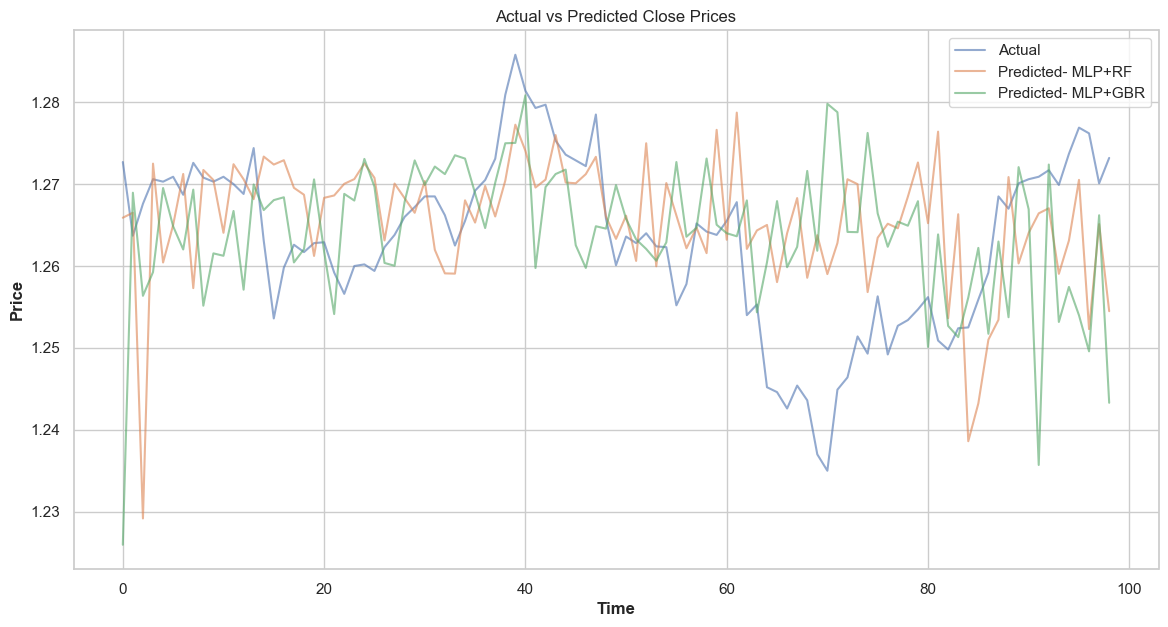

In [76]:
# Plot the actual vs predicted values
y_test_plt = y_new[-ii:]
y_test_plt.reset_index(inplace = True, drop = True)

plt.figure(figsize=(14, 7))
plt.plot(y_test_plt, label='Actual', alpha=0.6)
plt.plot(y_pred_mlp_rf, label='Predicted- MLP+RF', alpha=0.6)
plt.plot(y_pred_mlp_gbr, label='Predicted- MLP+GBR', alpha=0.6)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


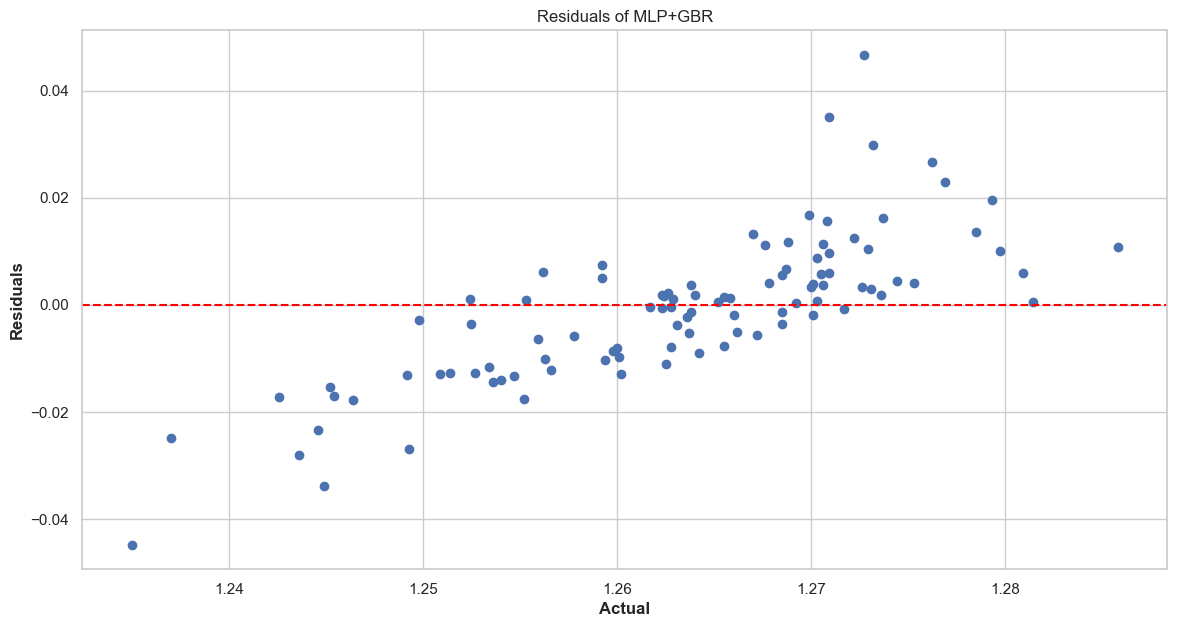

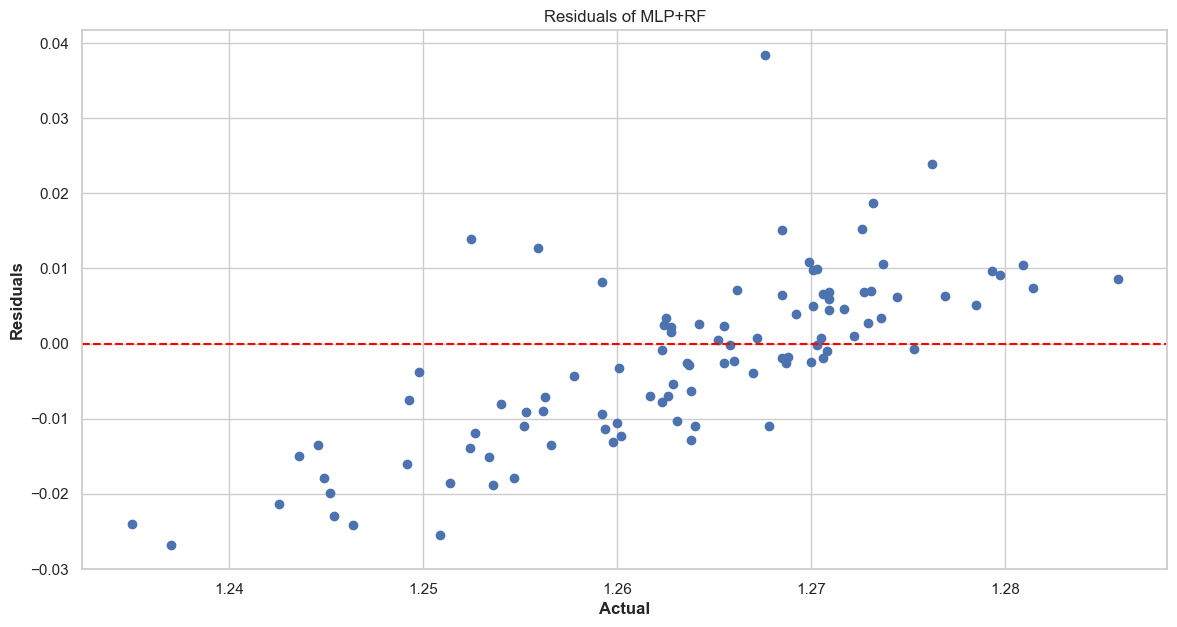

In [78]:
plot_residuals(y_test_plt, y_pred_mlp_gbr, 'MLP+GBR')
plot_residuals(y_test_plt, y_pred_mlp_rf, 'MLP+RF')

### 9.	Back testing the hybrid model 

In [81]:
hybrid_predictions_test = y_pred_mlp_gbr.T
# hybrid_predictions_test = y_pred_mlp_rf.T

test_index = iii-1 #X_test.shape[0]

N_TRAIN = 1000
class HybridModelStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):
        self.hybrid_predictions = self.I(lambda: hybrid_predictions_test, name='hybrid_predictions')
        self.clf = hybrid_predictions_test
        
        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        
        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        
    def next(self):
        self.position.close()
        # Buy if prediction is higher than the current price
        if self.data.Close[-1] < self.hybrid_predictions[-1]:
        #if self.hybrid_predictions[-1] > 0.007:

            # self.position.close()
            self.buy()
        # Sell if prediction is lower than the current price
        elif self.data.Close[-1] > self.hybrid_predictions[-1]:
        #elif self.hybrid_predictions[-1] < -0.007:
            # self.position.close() #sell()
            self.sell()#size=10

# Create a backtest instance
bt = Backtest(df.iloc[-test_index:], HybridModelStrategy, cash=10000, commission=.002)

# Run the backtest
output = bt.run()
print(output)

# set_bokeh_output(notebook=False)
a = output['_trades'] # trades
bt.plot()

Start                     2024-01-16 00:00:00
End                       2024-05-31 00:00:00
Duration                    136 days 00:00:00
Exposure Time [%]                   97.979798
Equity Final [$]                  8729.286713
Equity Peak [$]                       10000.0
Return [%]                         -12.707133
Buy & Hold Return [%]                0.039287
Return (Ann.) [%]                  -29.243863
Volatility (Ann.) [%]                 3.79479
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -12.707133
Avg. Drawdown [%]                  -12.707133
Max. Drawdown Duration      135 days 00:00:00
Avg. Drawdown Duration      135 days 00:00:00
# Trades                                   97
Win Rate [%]                        26.804124
Best Trade [%]                        0.89028
Worst Trade [%]                     -1.026434
Avg. Trade [%]                    

C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\mariam.000\anaconda3\Lib\site-packages\backtesting\_plotting.py:659: UserWarning: found m

GridPlot(id='p1316', ...)

### 10.	Optimization of individual and hybrid models.

In [ ]:
#OPTIMIZATION for MLP
# Define hyperparameters for GridSearch
mlp = MLPRegressor(max_iter=500, random_state=42)

# Default config
MLPRegressor(hidden_layer_sizes=(100,), activation='relu',  solver='adam', alpha=0.0001, batch_size='auto',
             learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
             random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
             early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
             n_iter_no_change=10, max_fun=15000,)

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (20, 20), (64, 32), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
# RF optimization
rf = RandomForestRegressor()

#Deafault Config
RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2,
                      min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None,
                      verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None,)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data (assuming X_train and y_train are your training data)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

In [ ]:
# GBR optimization
gbr = GradientBoostingRegressor()

# Default Config

GradientBoostingRegressor(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                          criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                          max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None,
                          alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1,
                          n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0,)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4],
    'subsample': [0.8, 0.9, 1.0],
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data (assuming X_train and y_train are your training data)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

In [ ]:
#Hybrid optimization
stacking_ensemble = StackingRegressor(estimators=[('mlp', mlp)], final_estimator=rf)
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50), (100,)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'lbfgs'],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=stacking_ensemble, param_grid=param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Best model
best_model = grid_search.best_estimator_
